### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device('cuda:0') # or you print here you favorite gpu card

torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2021-11-23 17:28:37--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2021-11-23 17:28:37 (37.4 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

cuda:0


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor).to(device)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor).to(device)

In [5]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


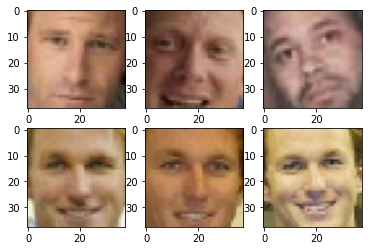

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [8]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [9]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [10]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [11]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:00, 401.42it/s]


1, Train loss: 0.10197196617998397, Test loss: 0.024101316577797578


370it [00:00, 417.47it/s]


2, Train loss: 0.02319856833475101, Test loss: 0.023296506766912563


370it [00:00, 430.08it/s]


3, Train loss: 0.022857422256081162, Test loss: 0.022903250674187674


370it [00:00, 436.99it/s]


4, Train loss: 0.02259256415295555, Test loss: 0.022837298781870716


370it [00:00, 442.11it/s]


5, Train loss: 0.02224714711611118, Test loss: 0.0222283714841039


370it [00:00, 447.72it/s]


6, Train loss: 0.021653426076286453, Test loss: 0.021308283752718978


370it [00:00, 418.73it/s]


7, Train loss: 0.02058005030858548, Test loss: 0.020123464555454575


370it [00:00, 430.96it/s]


8, Train loss: 0.019067391111943065, Test loss: 0.018553238232339144


370it [00:00, 420.10it/s]


9, Train loss: 0.01752784791468107, Test loss: 0.017179642713199213


370it [00:00, 421.34it/s]


10, Train loss: 0.016274644199627236, Test loss: 0.015854608186162952


370it [00:00, 423.22it/s]


11, Train loss: 0.014811960829207684, Test loss: 0.01428460465558721


370it [00:00, 421.90it/s]


12, Train loss: 0.013537534389675419, Test loss: 0.013508551655765639


370it [00:00, 434.55it/s]


13, Train loss: 0.012365371349734873, Test loss: 0.01211453268399521


370it [00:00, 428.67it/s]


14, Train loss: 0.01159439670962818, Test loss: 0.012216144733512764


370it [00:00, 460.93it/s]


15, Train loss: 0.010687911925919773, Test loss: 0.011169901398119995


370it [00:00, 453.51it/s]


16, Train loss: 0.01017239752226306, Test loss: 0.009861870245460808


370it [00:00, 427.20it/s]


17, Train loss: 0.009548718861736574, Test loss: 0.009103950913688935


370it [00:00, 394.61it/s]


18, Train loss: 0.009099451824479302, Test loss: 0.009015688675595821


370it [00:00, 415.71it/s]


19, Train loss: 0.008866358318786342, Test loss: 0.008434795444484873


370it [00:00, 424.85it/s]


20, Train loss: 0.008230510321114604, Test loss: 0.00810432941551861


370it [00:00, 433.55it/s]


21, Train loss: 0.008025973627495861, Test loss: 0.007956239957934


370it [00:00, 429.07it/s]


22, Train loss: 0.007747295640054277, Test loss: 0.007800611542846339


370it [00:00, 429.37it/s]


23, Train loss: 0.0076218169200597775, Test loss: 0.007781734790520376


370it [00:00, 448.51it/s]


24, Train loss: 0.007251423105868512, Test loss: 0.0071906575414499505


370it [00:00, 455.77it/s]


25, Train loss: 0.00709917216757317, Test loss: 0.007336340173728425


370it [00:00, 425.18it/s]


26, Train loss: 0.0069300812365399285, Test loss: 0.007768704274983672


370it [00:00, 401.29it/s]


27, Train loss: 0.006811567160598954, Test loss: 0.006913224759108893


370it [00:00, 435.31it/s]


28, Train loss: 0.0067020236650603675, Test loss: 0.006793128485918794


370it [00:00, 426.36it/s]


29, Train loss: 0.00652706631606022, Test loss: 0.006447526939506055


370it [00:00, 427.52it/s]


30, Train loss: 0.006470592475835789, Test loss: 0.0064619249888658095


370it [00:00, 427.36it/s]


31, Train loss: 0.006393630348735265, Test loss: 0.006632464543213645


370it [00:00, 434.08it/s]


32, Train loss: 0.006298605183716138, Test loss: 0.00657544066097448


370it [00:00, 442.06it/s]


33, Train loss: 0.00625303150465686, Test loss: 0.006362626779858778


370it [00:00, 424.23it/s]


34, Train loss: 0.00618607890267414, Test loss: 0.006212510265893852


370it [00:00, 432.11it/s]


35, Train loss: 0.006091267727382461, Test loss: 0.005999216383197677


370it [00:00, 423.83it/s]


36, Train loss: 0.006057217374012655, Test loss: 0.006083933350488621


370it [00:00, 424.08it/s]


37, Train loss: 0.00604245077889908, Test loss: 0.006153646254433997


370it [00:00, 413.27it/s]


38, Train loss: 0.005957697823170064, Test loss: 0.0059465292291549406


370it [00:00, 452.02it/s]


39, Train loss: 0.005967303571634209, Test loss: 0.006297855739342167


370it [00:00, 429.56it/s]

40, Train loss: 0.005965107823151697, Test loss: 0.006062860770508103


In [12]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.00607331466576394


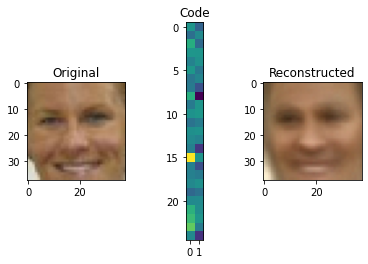

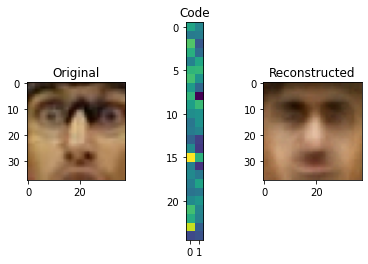

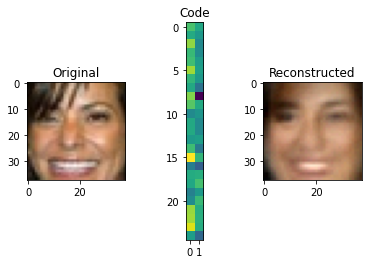

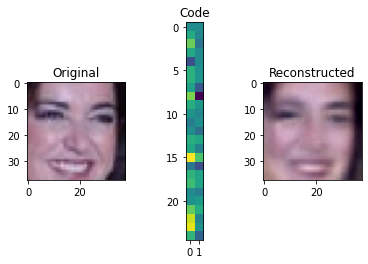

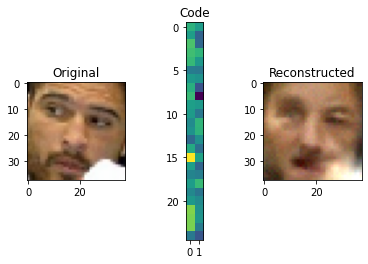

In [13]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [14]:

class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
      super(DeepAutoencoder, self).__init__()

      self.enc = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3),
                                nn.LeakyReLU(0.2),
                                nn.Conv2d(16, 32, kernel_size=3),
                                nn.LeakyReLU(0.1),
                                nn.Conv2d(32, 64, kernel_size=2), 
                                nn.LeakyReLU(0.2),
                                nn.MaxPool2d(4), 
          
                                nn.Flatten(),
                                nn.Linear(4096, code_size),
                                # nn.LeakyReLU(0.1),
                                # nn.Linear(2048, code_size)
                                )

      self.dec = nn.Sequential(nn.Linear(code_size, 4096), 
                              #  nn.LeakyReLU(0.1),
                              #  nn.Linear(2048, 4096),

                               nn.Unflatten(1, torch.Size([64, 8, 8])),
                               nn.Upsample(scale_factor=4),
                               nn.LeakyReLU(0.2),
                               nn.ConvTranspose2d(64, 32, 3),
                               nn.LeakyReLU(0.1),
                               nn.ConvTranspose2d(32, 16, 3),
                              #  nn.Upsample(scale_factor=2),
                               nn.LeakyReLU(0.2),
                               nn.ConvTranspose2d(16, 3, 3)
                                )
    
    def batch_loss(self, batch, reference):
      a = self.enc(batch)
      reconstruction = self.dec(a)
      return torch.mean((reference - reconstruction)**2)

In [15]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.float().to(device))
    print(encoder_out.shape)
    decoder_out = model.dec(encoder_out)
    print(decoder_out.shape)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

torch.Size([32, 1])
torch.Size([32, 3, 38, 38])
Testing code size 1
torch.Size([32, 8])
torch.Size([32, 3, 38, 38])
Testing code size 8
torch.Size([32, 32])
torch.Size([32, 3, 38, 38])
Testing code size 32
torch.Size([32, 128])
torch.Size([32, 3, 38, 38])
Testing code size 128
torch.Size([32, 512])
torch.Size([32, 3, 38, 38])
Testing code size 512
torch.Size([32, 1024])
torch.Size([32, 3, 38, 38])
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [16]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=40)

370it [00:13, 27.81it/s]


1, Train loss: 0.023818400460444263, Test loss: 0.01330601150760992


370it [00:13, 27.80it/s]


2, Train loss: 0.011802639852588748, Test loss: 0.011112449492611523


370it [00:13, 27.81it/s]


3, Train loss: 0.010177928462837695, Test loss: 0.009626891370723544


370it [00:13, 27.84it/s]


4, Train loss: 0.008714798797239248, Test loss: 0.00839185824892635


370it [00:13, 27.80it/s]


5, Train loss: 0.007723539472046623, Test loss: 0.007448324672928073


370it [00:13, 27.83it/s]


6, Train loss: 0.007159019749802467, Test loss: 0.0073586310797411555


370it [00:13, 27.85it/s]


7, Train loss: 0.00683294517418699, Test loss: 0.006775436594403449


370it [00:13, 27.87it/s]


8, Train loss: 0.006506757001368596, Test loss: 0.006867297109228797


370it [00:13, 27.91it/s]


9, Train loss: 0.006339477398973627, Test loss: 0.006407172698996484


370it [00:13, 27.84it/s]


10, Train loss: 0.006148677448974847, Test loss: 0.006212272277296856


370it [00:13, 27.86it/s]


11, Train loss: 0.006024135930754381, Test loss: 0.006133102380146386


370it [00:13, 27.83it/s]


12, Train loss: 0.0059350732768765, Test loss: 0.006180490183771252


370it [00:13, 27.89it/s]


13, Train loss: 0.005803725915780172, Test loss: 0.0060058483321655375


370it [00:13, 27.85it/s]


14, Train loss: 0.005733243932516265, Test loss: 0.005960840871819634


370it [00:13, 27.82it/s]


15, Train loss: 0.005649439293887703, Test loss: 0.005854157679354908


370it [00:13, 27.81it/s]


16, Train loss: 0.005587581037750831, Test loss: 0.0058600577403265415


370it [00:13, 27.86it/s]


17, Train loss: 0.005528964775440598, Test loss: 0.005737038624939523


370it [00:13, 27.78it/s]


18, Train loss: 0.00544464213140707, Test loss: 0.006221360372820506


370it [00:13, 27.87it/s]


19, Train loss: 0.005386330956848222, Test loss: 0.0057435938283548


370it [00:13, 27.74it/s]


20, Train loss: 0.005345947495096934, Test loss: 0.0056493986874302194


370it [00:13, 27.85it/s]


21, Train loss: 0.005316670505633623, Test loss: 0.005570628220447126


370it [00:13, 27.83it/s]


22, Train loss: 0.005223895174931967, Test loss: 0.0056204546632978875


370it [00:13, 27.82it/s]


23, Train loss: 0.0052320921472769856, Test loss: 0.005582204593248614


370it [00:13, 27.83it/s]


24, Train loss: 0.005176167814318111, Test loss: 0.005522639546848441


370it [00:13, 27.75it/s]


25, Train loss: 0.005159137889304173, Test loss: 0.0054153113367912025


370it [00:13, 27.79it/s]


26, Train loss: 0.005083951391836227, Test loss: 0.005518471721388142


370it [00:13, 27.84it/s]


27, Train loss: 0.005075572473686237, Test loss: 0.005525359174399709


370it [00:13, 27.82it/s]


28, Train loss: 0.005027229281585457, Test loss: 0.005402200264129022


370it [00:13, 27.84it/s]


29, Train loss: 0.004990270234452477, Test loss: 0.005358215102439033


370it [00:13, 27.88it/s]


30, Train loss: 0.00495077594294022, Test loss: 0.005335481687387498


370it [00:13, 27.94it/s]


31, Train loss: 0.004910402483737626, Test loss: 0.005304490422796281


370it [00:13, 27.91it/s]


32, Train loss: 0.004882823139658032, Test loss: 0.005320490803598842


370it [00:13, 27.81it/s]


33, Train loss: 0.0048601398200002225, Test loss: 0.005261564506845144


370it [00:13, 27.87it/s]


34, Train loss: 0.00482799989515087, Test loss: 0.005441830815894573


370it [00:13, 27.91it/s]


35, Train loss: 0.00481386590179175, Test loss: 0.0052321328531002905


370it [00:13, 27.87it/s]


36, Train loss: 0.004783767404162317, Test loss: 0.005222863459509846


370it [00:13, 27.81it/s]


37, Train loss: 0.004762979214725363, Test loss: 0.005208806877459121


370it [00:13, 27.88it/s]


38, Train loss: 0.004752008991228075, Test loss: 0.005314767755826523


370it [00:13, 27.88it/s]


39, Train loss: 0.004715972626787779, Test loss: 0.00528704158643073


370it [00:13, 27.84it/s]


40, Train loss: 0.004710465191416973, Test loss: 0.005231557900552469


Training may take long, it's okay.

Final MSE: 0.005256087709303125


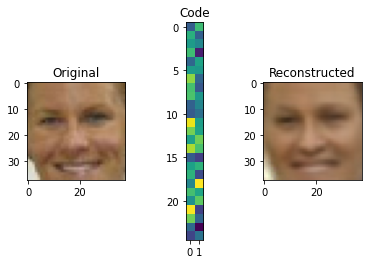

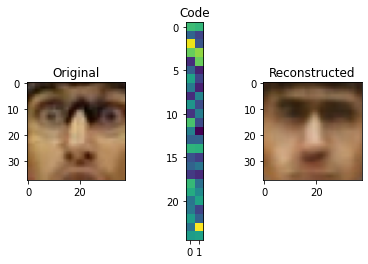

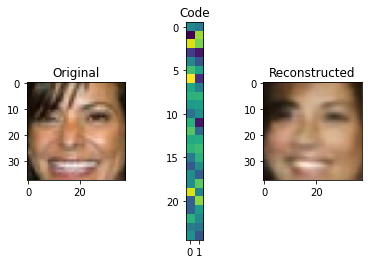

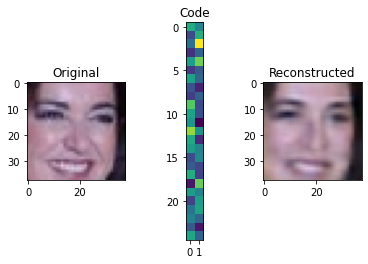

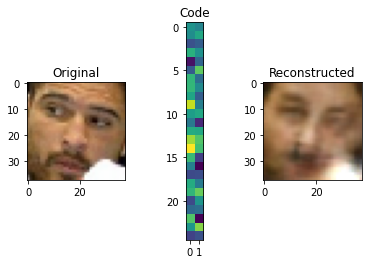

In [17]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

In [18]:
reconstruction_mse 

0.005256087709303125

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [19]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.randn(X.size()) * sigma
        
    return X + noise
    

In [20]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]).to(device), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]).to(device), sigma=0.5).mean() - torch.from_numpy(X[:100]).to(device).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

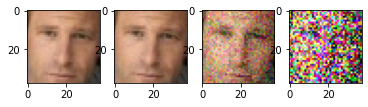

In [21]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]).to(device), sigma=0.01).data.cpu().numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]).to(device), sigma=0.1).data.cpu().numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]).to(device), sigma=0.5).data.cpu().numpy()[0].transpose([1,2,0]).clip(0, 1))

In [22]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40, noise_function=apply_gaussian_noise)

370it [00:13, 27.71it/s]


1, Train loss: 0.02660910007411625, Test loss: 0.016196859899698015


370it [00:13, 27.94it/s]


2, Train loss: 0.01324537140119596, Test loss: 0.012787034869331677


370it [00:13, 27.92it/s]


3, Train loss: 0.011070569920789825, Test loss: 0.01089472794959944


370it [00:13, 27.98it/s]


4, Train loss: 0.00987517898995013, Test loss: 0.010250997968349027


370it [00:13, 27.88it/s]


5, Train loss: 0.008925295585584261, Test loss: 0.008904759439875507


370it [00:13, 27.94it/s]


6, Train loss: 0.008002030682124088, Test loss: 0.007910468552470845


370it [00:13, 27.98it/s]


7, Train loss: 0.007509146916826868, Test loss: 0.007529402266119877


370it [00:13, 27.95it/s]


8, Train loss: 0.007076087351760532, Test loss: 0.007099373745351212


370it [00:13, 27.97it/s]


9, Train loss: 0.006878548933505951, Test loss: 0.006922966762056689


370it [00:13, 27.96it/s]


10, Train loss: 0.006629656831459091, Test loss: 0.006651994896049799


370it [00:13, 27.89it/s]


11, Train loss: 0.006479973320669327, Test loss: 0.006457318377837841


370it [00:13, 27.93it/s]


12, Train loss: 0.006343671976214238, Test loss: 0.0064290773172289055


370it [00:13, 28.00it/s]


13, Train loss: 0.006218022980249016, Test loss: 0.006275682601987283


370it [00:13, 27.96it/s]


14, Train loss: 0.006115763169807239, Test loss: 0.00612889805975209


370it [00:13, 27.97it/s]


15, Train loss: 0.006012935839357941, Test loss: 0.0059981524812253145


370it [00:13, 27.96it/s]


16, Train loss: 0.005933580499872063, Test loss: 0.0062095483758430785


370it [00:13, 27.95it/s]


17, Train loss: 0.005857493251518179, Test loss: 0.005936629354109359


370it [00:13, 27.91it/s]


18, Train loss: 0.005785482898589071, Test loss: 0.005815059840977581


370it [00:13, 27.96it/s]


19, Train loss: 0.005730629307878259, Test loss: 0.006011997852410454


370it [00:13, 27.85it/s]


20, Train loss: 0.005650152110255013, Test loss: 0.00580532361138197


370it [00:13, 27.92it/s]


21, Train loss: 0.005611671182852875, Test loss: 0.005710609488479075


370it [00:13, 27.90it/s]


22, Train loss: 0.005545357281558081, Test loss: 0.0056515162167246925


370it [00:13, 27.93it/s]


23, Train loss: 0.005512753282113205, Test loss: 0.00564409858058814


370it [00:13, 27.94it/s]


24, Train loss: 0.0054652521563285875, Test loss: 0.005619025172621327


370it [00:13, 27.91it/s]


25, Train loss: 0.005415640843420851, Test loss: 0.00563736965499816


370it [00:13, 27.98it/s]


26, Train loss: 0.0053753440633979134, Test loss: 0.005534529865901129


370it [00:13, 27.90it/s]


27, Train loss: 0.005335596688854323, Test loss: 0.005563845091029313


370it [00:13, 27.92it/s]


28, Train loss: 0.005296868108944497, Test loss: 0.005443619247530567


370it [00:13, 27.97it/s]


29, Train loss: 0.005251271680451877, Test loss: 0.005447201579065291


370it [00:13, 27.90it/s]


30, Train loss: 0.0051943706579158965, Test loss: 0.0053678431452305565


370it [00:13, 27.94it/s]


31, Train loss: 0.005152325947809329, Test loss: 0.005419199446341654


370it [00:13, 27.95it/s]


32, Train loss: 0.005123763491968865, Test loss: 0.005391206888516064


370it [00:13, 27.88it/s]


33, Train loss: 0.005095144820856395, Test loss: 0.005295059037289216


370it [00:13, 27.97it/s]


34, Train loss: 0.005061455330563187, Test loss: 0.005411103280365969


370it [00:13, 27.88it/s]


35, Train loss: 0.0050406604027534605, Test loss: 0.0052384138517331015


370it [00:13, 28.00it/s]


36, Train loss: 0.00500850767798271, Test loss: 0.00525590442098955


370it [00:13, 27.95it/s]


37, Train loss: 0.004987287163345555, Test loss: 0.005194868012411133


370it [00:13, 27.91it/s]


38, Train loss: 0.0049695690579456995, Test loss: 0.005411469343697727


370it [00:13, 27.97it/s]


39, Train loss: 0.004940427123849412, Test loss: 0.005234629546690338


370it [00:13, 27.99it/s]


40, Train loss: 0.004923668447077409, Test loss: 0.005225450733693748


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005367238647077934


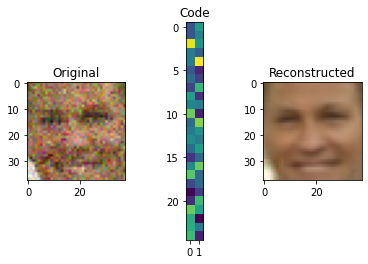

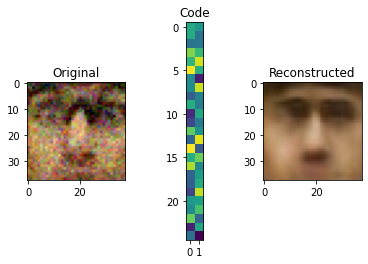

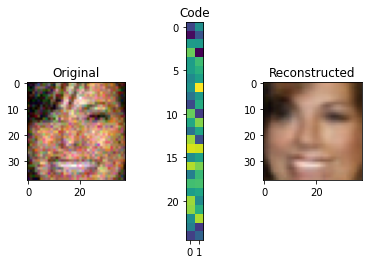

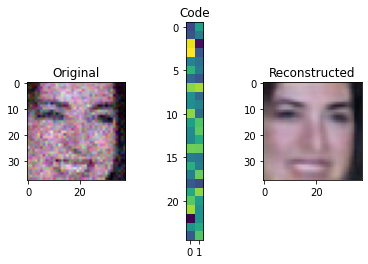

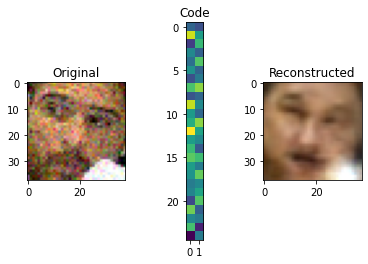

In [23]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [24]:
X_train_tensor.shape

torch.Size([11828, 3, 38, 38])

### I don't know what the problem, but I did almost all in this homework, so I don't want to deal with this problem

In [25]:
#encodes batch of images into a codes


# codes = <encode all images in X_train_tensor>

codes = torch.cat([aenc.enc(X_train_tensor[i][None].to(device=device)) for i in range(len(X_train_tensor))])


RuntimeError: ignored

In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test_tensor[2])

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

In [ ]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.